In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
sys.path.append('../src/')
import helpers as h
%matplotlib inline

In [2]:
def import_msprime_sfs(file_list, n_samples):
    n_files = len(file_list)
    mSFS = np.zeros((n_files, n_samples-1))
    jSFS_triu = np.zeros((n_files, n_samples*(n_samples-1)//2))
    
    # Import data from files
    for i, f in enumerate(file_list):
        with open(f) as datafile:
            for line in datafile:
                # Skip header lines
                if line.startswith('#'):
                    continue
                # First two non-header lines contain the marginal and joint SFS
                mSFS[i,:] = np.array(line.split(), dtype=float)
                jSFS_triu[i,:] = np.array(datafile.readline().split())
                break
                
    # Unpack the joint SFS
    jSFS = np.zeros((n_files, n_samples-1, n_samples-1))
    for i in range(n_files):
        jSFS[i,:,:][np.triu_indices(n_samples-1)] = jSFS_triu[i,:]
        # Don't double-count the diagonal values
        jSFS[i,:,:][np.diag_indices(n_samples-1)] /= 2
    # Symmetrize distribution
    jSFS += np.transpose(jSFS, axes=(0,2,1))
    
    # Fold marginal and joint SFS.
    mSFS_fold = (mSFS + mSFS[:,::-1])[:,:n_samples//2]
    jSFS_fold = (jSFS + jSFS[:,::-1,:] + jSFS[:,:,::-1] + jSFS[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
    # Don't double-count the n/2 = n - n/2 values.
    if n_samples % 2 == 0:
        mSFS_fold[:,-1] /= 2
        jSFS_fold[:,-1,:-1] /= 2
        jSFS_fold[:,:-1,-1] /= 2
        jSFS_fold[:,-1,-1] /= 4

    pi = h.sfs2pi(mSFS_fold.T, n_samples)

    return pi, mSFS_fold, jSFS_fold

In [3]:
n_samples = 100

Import SLiM output

In [52]:
fn_slim = '../simulations/slim/sweeps_fsel-0.0_corrmerged.txt.gz'
r_slim = 1e-8
mu = 1e-7
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)

lohi_corr_slim = np.zeros((n_samples//2 - 1, dist.shape[0]))
with gzip.open(fn_slim, 'rb') as infile:
    # SFS header and SFS
    infile.readline()
    sfs_slim = np.array(infile.readline().split(), dtype=float)
    # PI_CORR header and PI_CORR
    infile.readline()
    pi_corr_slim = np.array(infile.readline().split(), dtype=float)
    # LOHI_CORR header and LOHI_CORR
    infile.readline()
    for j, line in enumerate(infile):
        lohi_corr_slim[j,:] = line.split()
    pi_slim = h.sfs2pi(sfs_slim, n_samples)
    lo_slim = np.cumsum(sfs_slim)[:-1]
    hi_slim = np.sum(sfs_slim) - lo_slim
d_c = (2.0*mu_slim)/(pi_slim*r_slim)

In [53]:
fn_mssl = '../simulations/slim/msprime_fsel-0.0_corrmerged.txt.gz'

lohi_corr_mssl = np.zeros((n_samples//2 - 1, dist.shape[0]))
with gzip.open(fn_mssl, 'rb') as infile:
    # SFS header and SFS
    infile.readline()
    sfs_mssl = np.array(infile.readline().split(), dtype=float)
    # PI_CORR header and PI_CORR
    infile.readline()
    pi_corr_mssl = np.array(infile.readline().split(), dtype=float)
    # LOHI_CORR header and LOHI_CORR
    infile.readline()
    for j, line in enumerate(infile):
        lohi_corr_mssl[j,:] = line.split()
    pi_mssl = h.sfs2pi(sfs_mssl, n_samples)
    lo_mssl = np.cumsum(sfs_mssl)[:-1]
    hi_mssl = np.sum(sfs_mssl) - lo_mssl
    
print((2.0*mu_slim)/(pi_slim*r_slim))
print((2.0*mu_slim)/(pi_mssl*r_slim))

100664.722637
100091.073616


Import msprime output

In [54]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)[:-3]
file_list = ['../simulations/jsfs_a-2.0_r-{}.txt'.format(r) for r in r_list]
pi_mspr, sfs_mspr, jsfs_mspr = import_msprime_sfs(file_list, n_samples)
print(np.sum(sfs_mspr,axis=1), np.sum(jsfs_mspr,axis=(1,2)))
print(jsfs_mspr[0]/(sfs_mspr[0][:,None]*sfs_mspr[0][None:]) - 1)

[ 10.35395282  10.35319482  10.35075289  10.35960405  10.35639108
  10.35923684  10.35292236  10.35545646  10.35336399  10.36067743
  10.3605392 ] [ 113.70971211  112.89291339  112.21476711  111.3305815   109.99463032
  108.91465387  108.0060886   107.6295923   107.33450786  107.41623982
  107.37229643]
[[  1.03078209e-01  -1.01761191e-02  -1.00214298e-02 ...,  -1.31907104e-02
   -1.34832747e-02  -1.01836333e-02]
 [ -1.01761191e-02   3.67109324e-01  -1.79059171e-02 ...,  -3.05061259e-02
   -3.02995211e-02  -4.52591585e-02]
 [ -1.00214298e-02  -1.79059171e-02   7.55153596e-01 ...,  -1.58312948e-02
   -5.27763484e-02  -2.72818490e-02]
 ..., 
 [ -1.31907104e-02  -3.05061259e-02  -1.58312948e-02 ...,   3.35968797e+01
   -5.33510487e-01  -5.26600392e-01]
 [ -1.34832747e-02  -3.02995211e-02  -5.27763484e-02 ...,  -5.33510487e-01
    3.40993944e+01  -5.52055738e-01]
 [ -1.01836333e-02  -4.52591585e-02  -2.72818490e-02 ...,  -5.26600392e-01
   -5.52055738e-01   7.15575395e+01]]


In [55]:
#lohi_corr_slim = np.zeros((n_samples//2 - 1, len(r_list)))
pi_corr_mspr = np.zeros(len(r_list))
pi_weights = h.pairwise_diversity(np.arange(1, n_samples//2+1), n_samples)

lolo_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
lohi_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
hihi_corr_mspr = np.zeros((n_samples//2 - 1, len(r_list)))
for i in range(len(r_list)):
    jsfs = jsfs_mspr[i]
    msfs = sfs_mspr[i]

    pi = pi_mspr[i]
    pi_sq = np.sum(jsfs * pi_weights[:,None] * pi_weights[None,:])
    pi_corr_mspr[i] = pi_sq - pi**2
    
    for cutoff in np.arange(1, n_samples//2):
        j = cutoff - 1
        lo = np.sum(msfs[:cutoff])
        hi = np.sum(msfs[cutoff:])
        lolo = np.sum(jsfs[:cutoff, :cutoff])
        lohi = np.sum(jsfs[:cutoff, cutoff:])
        hihi = np.sum(jsfs[cutoff:, cutoff:])
        #print(np.sum(msfs), lo, hi, lolo, lohi, hihi, lolo+2*lohi+hihi)
        #print(lohi/(lo*hi))
        lolo_corr_mspr[j,i] = lolo / (lo*lo) - 1
        lohi_corr_mspr[j,i] = lohi / (lo*hi) - 1
        hihi_corr_mspr[j,i] = hihi / (hi*hi) - 1

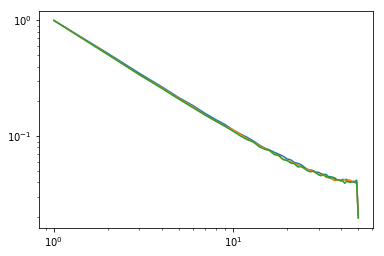

In [56]:
plt.loglog(np.arange(1,n_samples//2+1), sfs_slim/sfs_slim[0])
plt.loglog(np.arange(1,n_samples//2+1), sfs_mssl/sfs_mssl[0])
plt.loglog(np.arange(1,n_samples//2+1), sfs_mspr[0]/sfs_mspr[0,0])

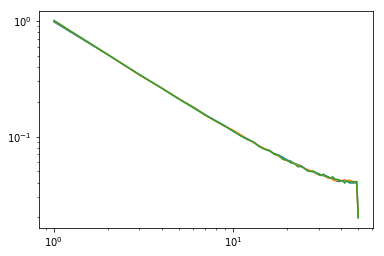

In [57]:
plt.loglog(np.arange(1,n_samples//2+1), sfs_slim/pi_slim)
plt.loglog(np.arange(1,n_samples//2+1), sfs_mssl/pi_mssl)


plt.loglog(np.arange(1,n_samples//2+1), sfs_mspr[0]/pi_mspr[0])

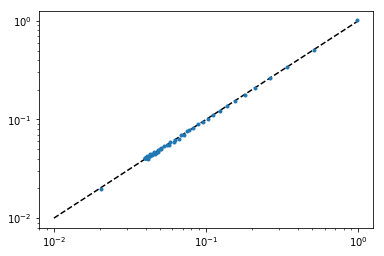

In [9]:
plt.loglog([0.01,1.0],[0.01,1.0], '--k')
plt.loglog(sfs_slim/pi_slim, sfs_mspr[0]/pi_mspr[0], '.')

(-0.01, 0.21)

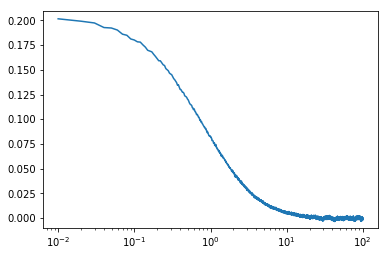

In [10]:
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([-0.01,0.21])

(-0.01, 0.21)

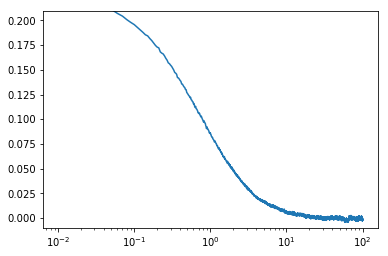

In [58]:
plt.semilogx(dist/1e5, pi_corr_mssl/pi_mssl**2)
plt.ylim([-0.01,0.21])

(-0.01, 0.21)

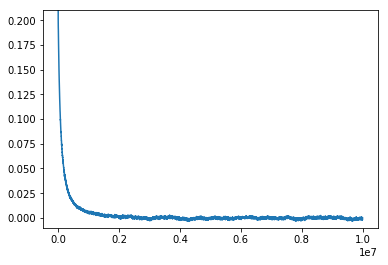

In [11]:
plt.plot(dist, pi_corr_slim/pi_slim**2)
plt.ylim([-0.01,0.21])

(0.001, 0.3)

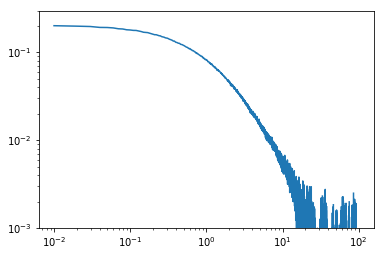

In [12]:
plt.loglog(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([1e-3,0.3])

(-1, 21)

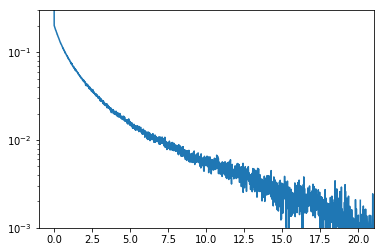

In [13]:
plt.semilogy(dist/d_c, pi_corr_slim/pi_slim**2)
plt.ylim([1e-3,0.3])
plt.xlim([-1,21])

(-0.01, 1.01)

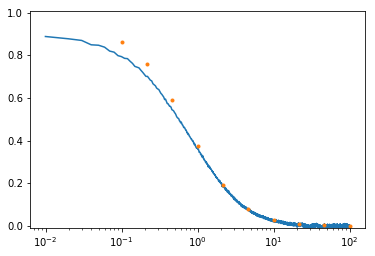

In [14]:
plt.semilogx(dist/d_c, (pi_corr_slim*2.0**2)/(pi_slim**2*pi_corr_mspr[0]))
plt.semilogx(r_list*pi_mspr/2, pi_corr_mspr/pi_corr_mspr[0], '.')
plt.ylim([-0.01,1.01])
#plt.ylim([-0.01,0.26])
#plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

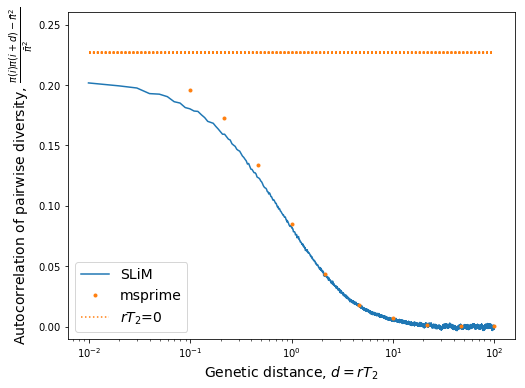

In [51]:
fs=14
plt.figure(figsize=(8, 6))
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2, label='SLiM')
plt.semilogx(r_list, pi_corr_mspr/pi_mspr**2, '.', label='msprime')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100, color='C1', linestyle='dotted', label='$rT_2$=0')

plt.xlabel('Genetic distance, $d=rT_2$', fontsize=fs)
plt.ylabel(r'Autocorrelation of pairwise diversity, $\frac{\pi(i)\pi(i+d)-\bar{\pi}^2}{\bar{\pi}^2}$', fontsize=fs)
plt.legend(loc=3, fontsize=fs)
#plt.ylim([-0.1,1.1])
plt.savefig('pi_autoccorrelation.pdf')

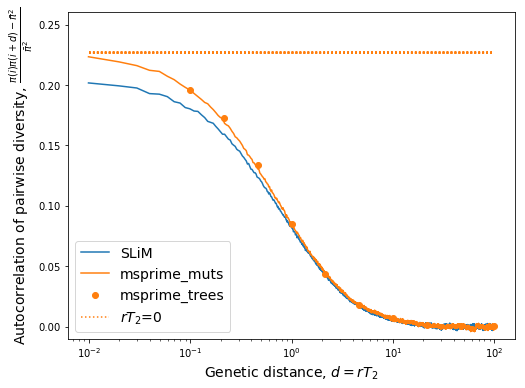

In [60]:
fs=14
plt.figure(figsize=(8, 6))
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2, color='C0', label='SLiM')
plt.semilogx(dist/d_c, pi_corr_mssl/pi_mssl**2, color='C1', label='msprime_muts')
plt.semilogx(r_list, pi_corr_mspr/pi_mspr**2, 'o', color='C1', label='msprime_trees')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100, color='C1', linestyle='dotted', label='$rT_2$=0')

plt.xlabel('Genetic distance, $d=rT_2$', fontsize=fs)
plt.ylabel(r'Autocorrelation of pairwise diversity, $\frac{\pi(i)\pi(i+d)-\bar{\pi}^2}{\bar{\pi}^2}$', fontsize=fs)
plt.legend(loc=3, fontsize=fs)
#plt.ylim([-0.1,1.1])
plt.savefig('pi_autoccorrelation.pdf')

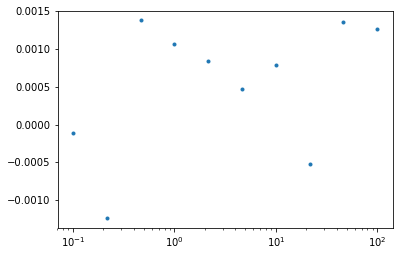

In [218]:
plt.semilogx(r_list, np.log(pi_mspr/2), '.')

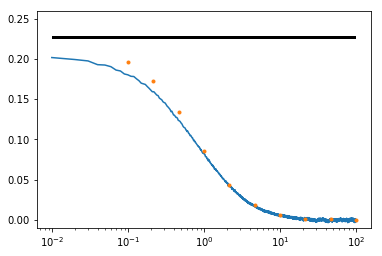

In [208]:
plt.semilogx(dist/d_c, pi_corr_slim/pi_slim**2)
plt.semilogx(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

(-0.01, 0.26)

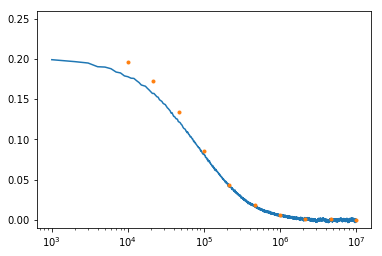

In [250]:
plt.semilogx(dist, pi_corr_slim/(2e-4)**2)
plt.semilogx(r_list*1e5, pi_corr_mspr/4, '.')
plt.ylim([-0.01,0.26])

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


(-0.75, 0.1)

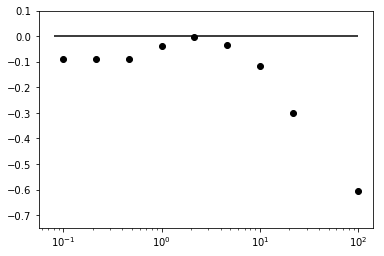

In [270]:
for i, r in enumerate(r_list):
    #plt.semilogx(dist, pi_corr_slim/(2e-4)**2)
    pcs = pi_corr_slim[np.argmin(np.abs(r - dist/1e5))]*1e8
    #print(pcs)
    #plt.semilogx(r, pcs/(2e-4)**2, 'ob')
    #print(pcs/(2e-4)**2)
    #print(pcs*1e8/4)
    plt.semilogx(r, pcs/pi_corr_mspr[i] - 1, 'ok')
plt.hlines(0,0.08,100)
plt.ylim([-0.75,0.1])

(-0.75, 0.1)

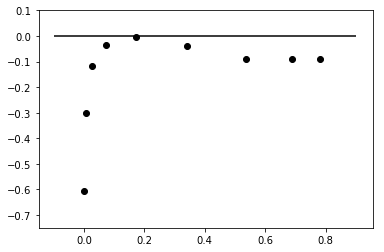

In [274]:
for i, r in enumerate(r_list):
    pcs = pi_corr_slim[np.argmin(np.abs(r - dist/1e5))]*1e8
    plt.plot(pi_corr_mspr[i], pcs/pi_corr_mspr[i] - 1, 'ok')
plt.hlines(0,-0.1,0.9)
plt.ylim([-0.75,0.1])

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


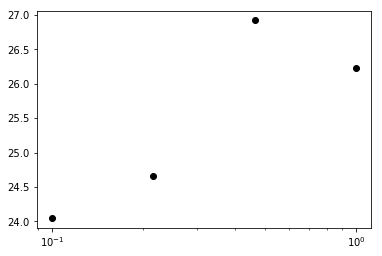

In [287]:
cutoff = 5
for i, r in enumerate(r_list[:5]):
    lcs = lohi_corr_slim[cutoff,np.argmin(np.abs(r - dist/1e5))]*1e8
    plt.semilogx(r, np.abs(lcs/lohi_corr_mspr[cutoff,i]) - 1, 'ok')
#plt.hlines(0,-0.1,0.9)
#plt.ylim([-0.75,0.1])

In [246]:
print(dist/d_c)
print(r_list[1])
np.argmin(np.abs(dist/d_c - r_list[1]))
print(dist[10]/d_c)

[  0.00000000e+00   9.93396667e-03   1.98679333e-02 ...,   9.93197988e+01
   9.93297328e+01   9.93396667e+01]
0.1
0.0993396667475


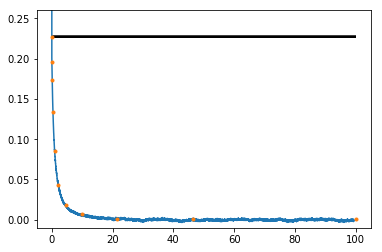

In [209]:
plt.plot(dist/d_c, pi_corr_slim/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.26])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

In [201]:
print(pi_corr_mspr/4)

[ 0.22699856  0.19551074  0.17248461  0.1341002   0.08517395  0.04329303
  0.01817844  0.00673656  0.00150183  0.00073924  0.00033557]


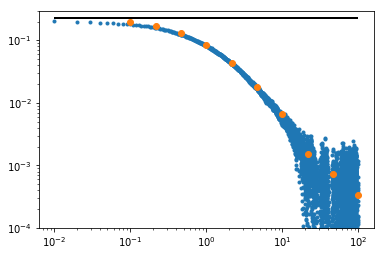

In [167]:
plt.loglog(dist/d_c, pi_corr_slim/pi_slim**2, '.')
plt.loglog(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, 'o')
plt.ylim([1e-4,0.3])
plt.hlines(pi_corr_mspr[0]/pi_mspr**2, 0.01, 100)


#plt.ylim([-0.1,1.1])

(0, 20)

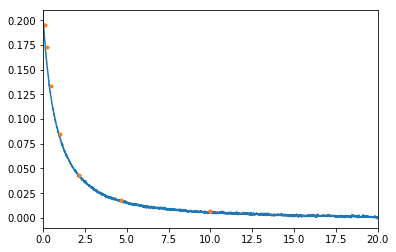

In [168]:
plt.plot(dist/d_c, pi_corr_slim/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.21])
plt.xlim([0,20])
#plt.ylim([-0.1,1.1])

(-0.1, 2.1)

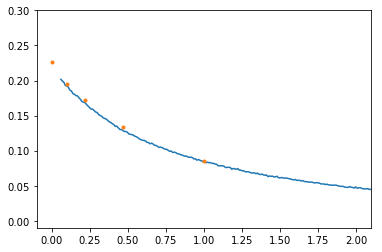

In [199]:
plt.plot((dist[1:]+5*w)/d_c, pi_corr_slim[1:]/pi_slim**2)
plt.plot(r_list*pi_mspr/2, pi_corr_mspr/pi_mspr**2, '.')
plt.ylim([-0.01,0.3])
plt.xlim([-0.1,2.1])
#plt.ylim([-0.1,1.1])

In [170]:
print(pi_corr_slim[1]/pi_slim**2)
print(pi_corr_mspr[0]/pi_mspr[0]**2)

0.201648924783
0.227034641774


In [171]:
print(pi_slim)
print(pi_corr_slim[1])

0.000198679333495
7.95978430701e-09


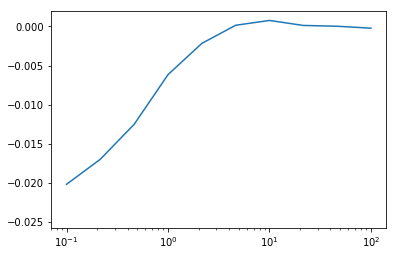

In [172]:
plt.semilogx(r_list*pi_mspr/2, lohi_corr_mspr[5], '-')

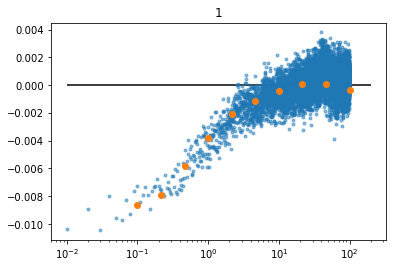

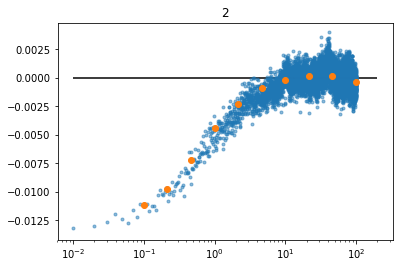

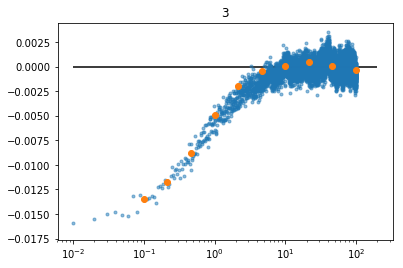

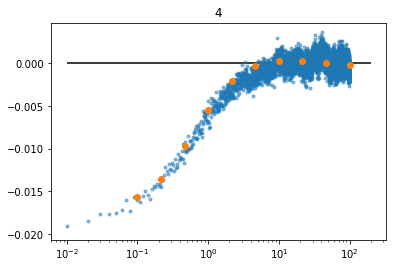

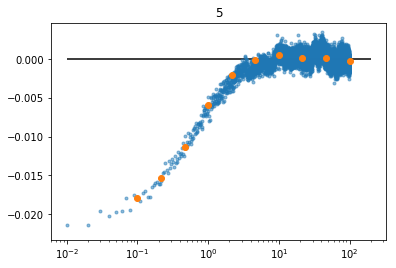

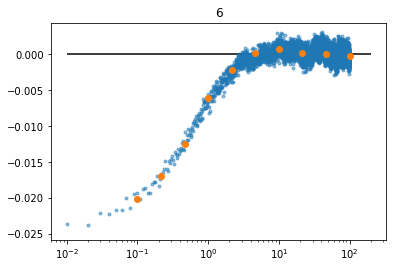

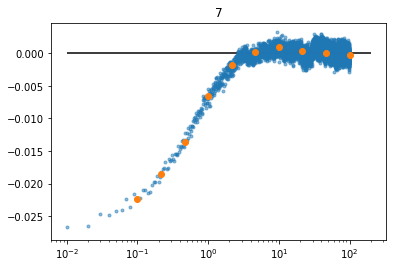

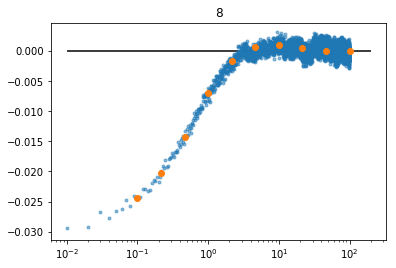

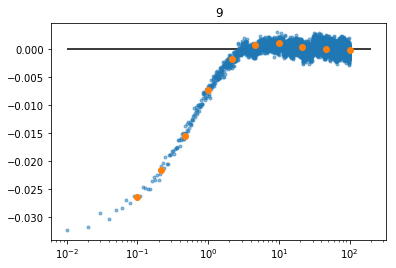

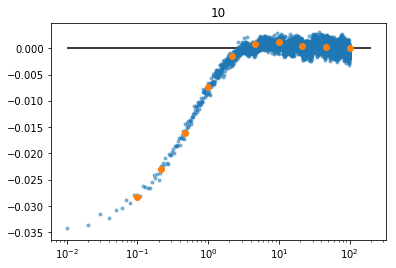

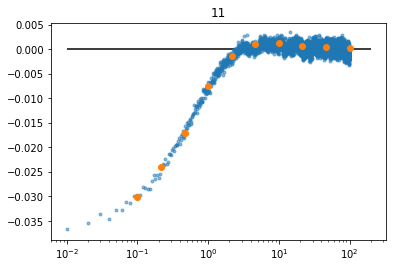

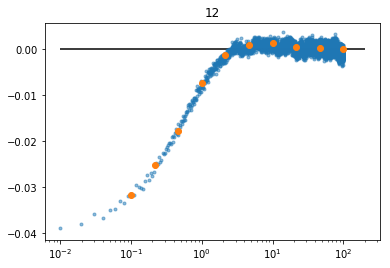

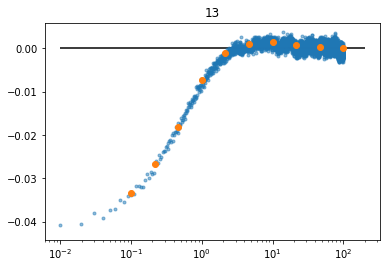

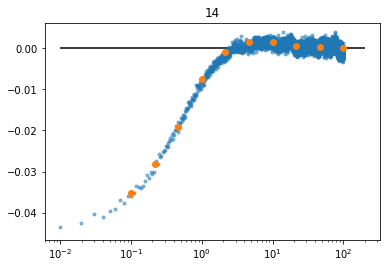

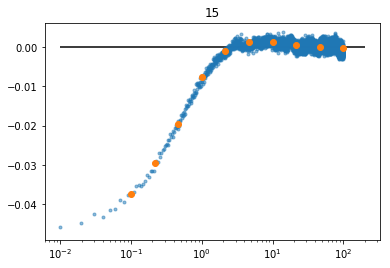

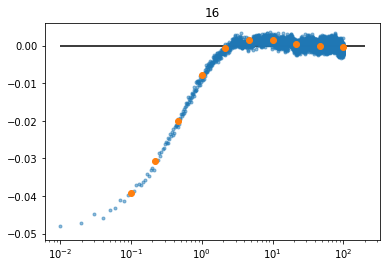

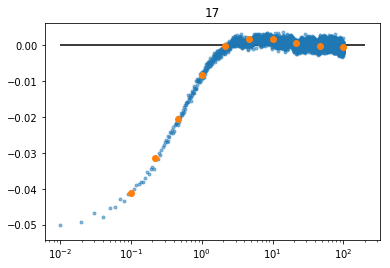

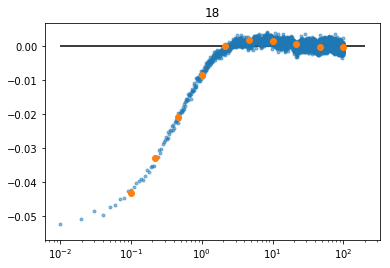

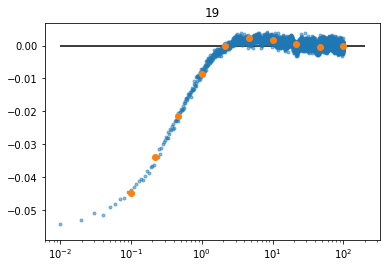

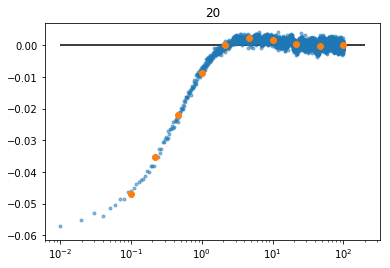

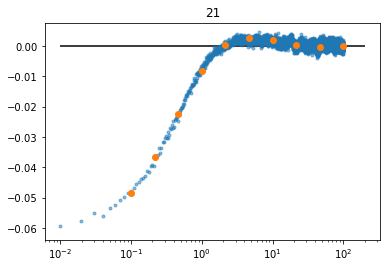

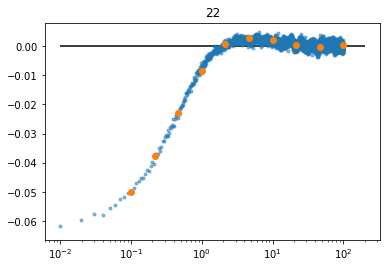

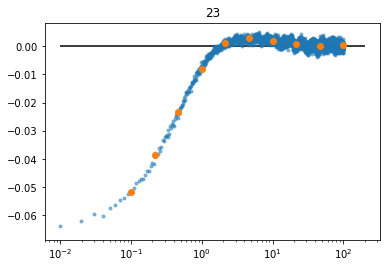

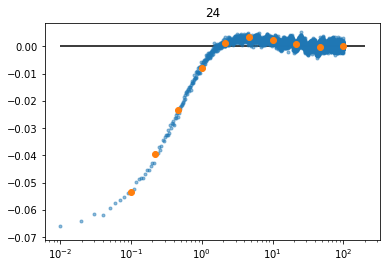

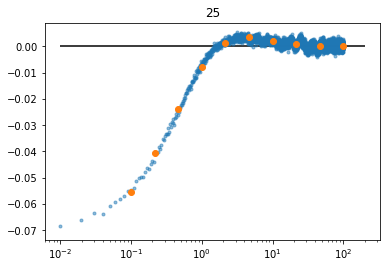

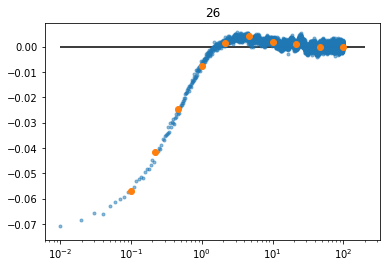

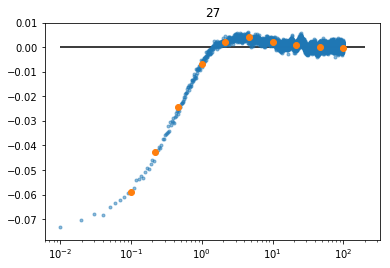

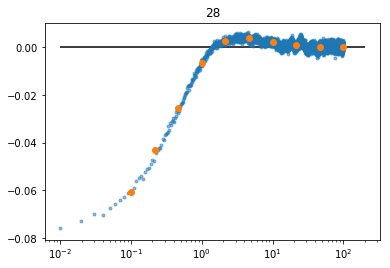

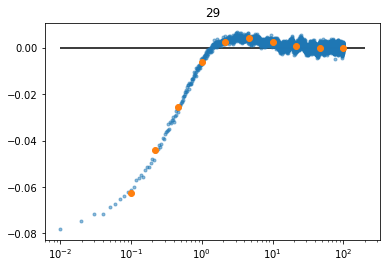

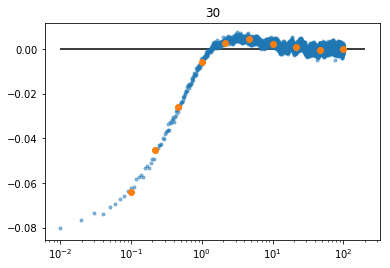

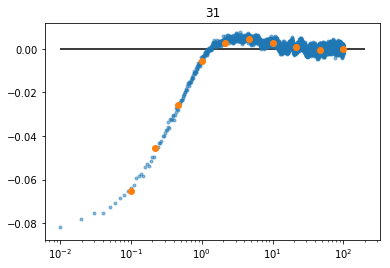

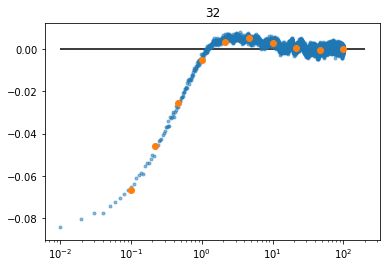

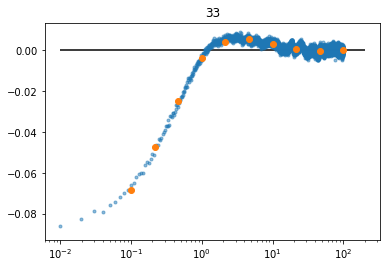

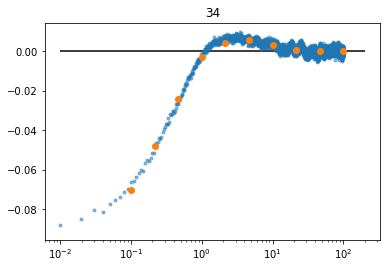

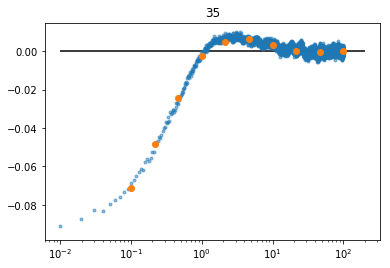

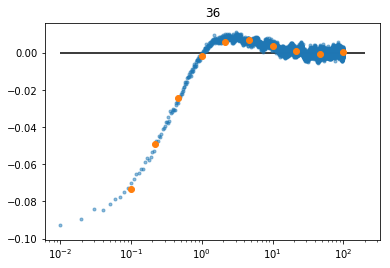

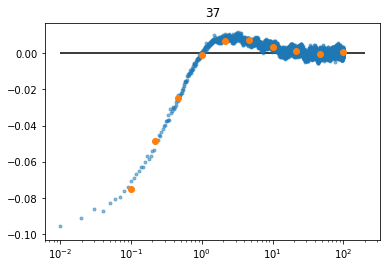

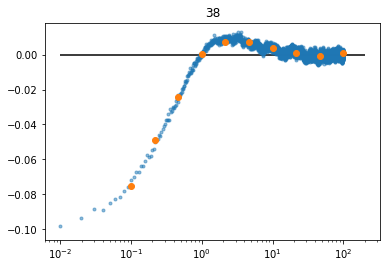

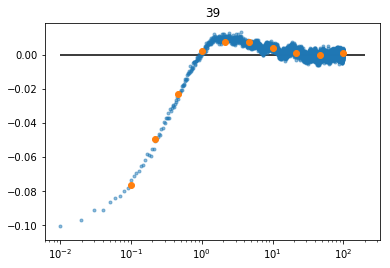

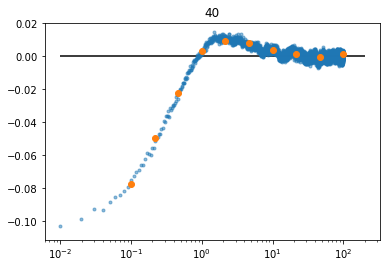

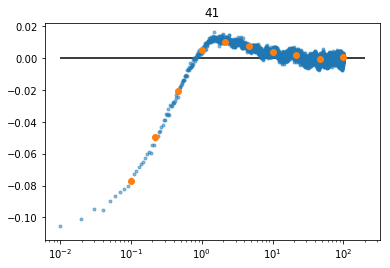

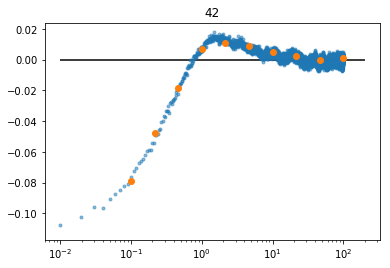

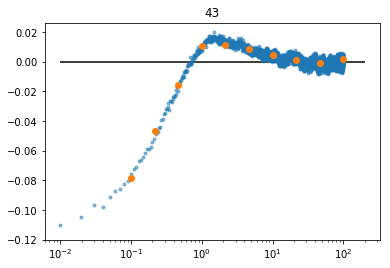

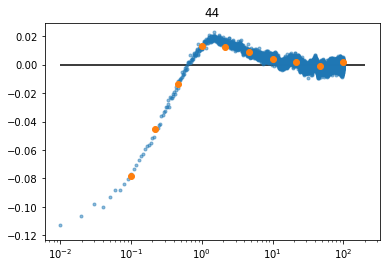

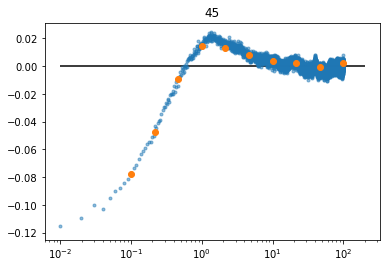

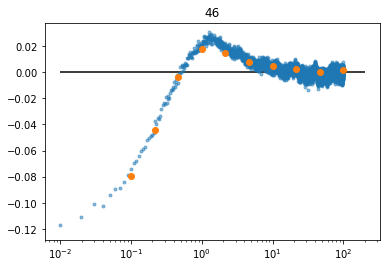

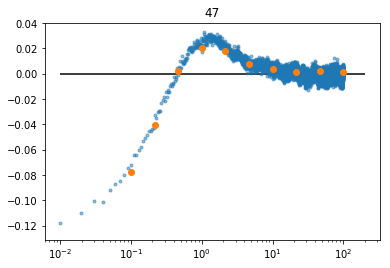

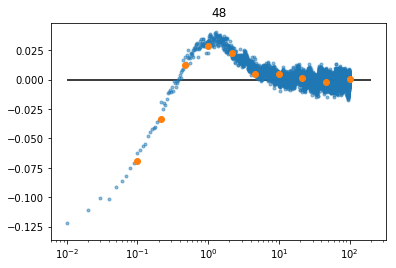

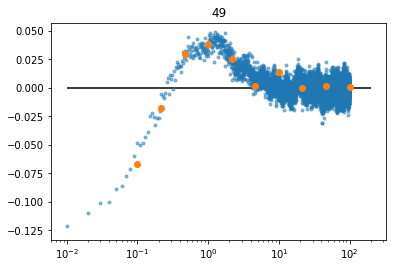

In [173]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.semilogx(dist/d_c, lohi_corr_slim[i]/(lo_slim[i]*hi_slim[i]), '.', alpha=0.5)
    plt.semilogx(r_list*pi_mspr/2, lohi_corr_mspr[i], 'o')
    plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.show()

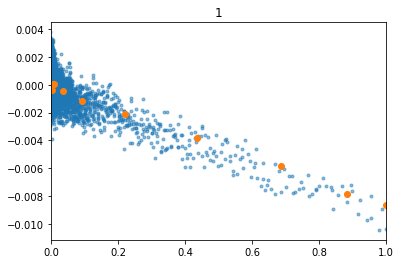

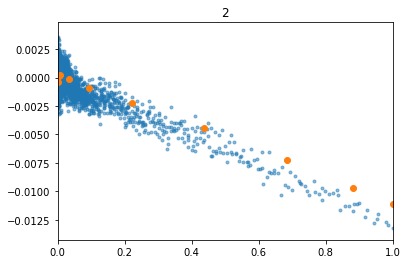

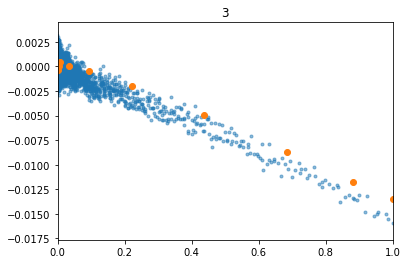

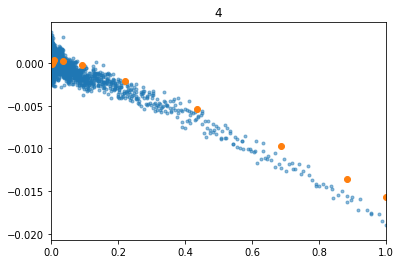

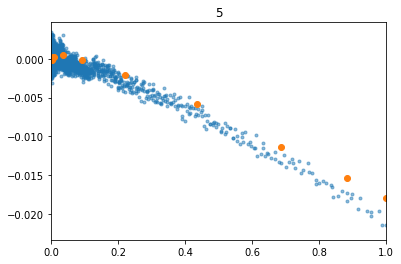

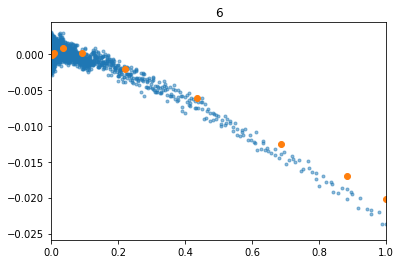

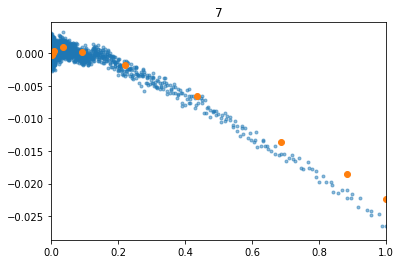

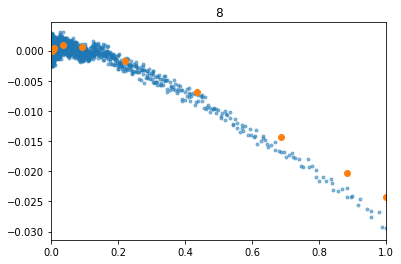

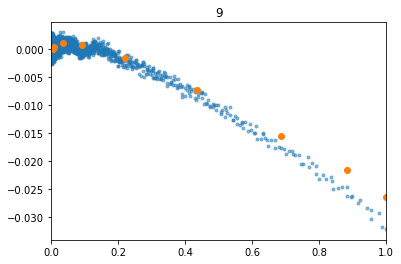

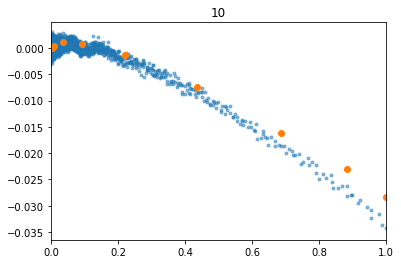

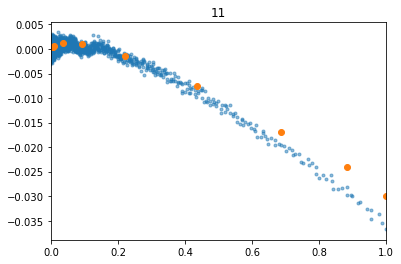

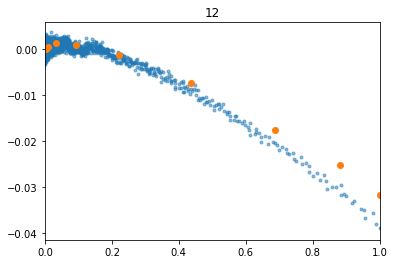

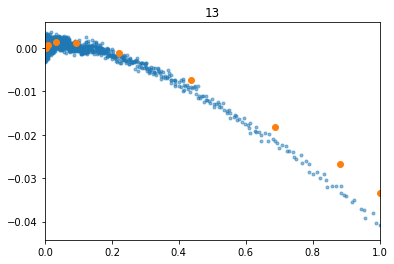

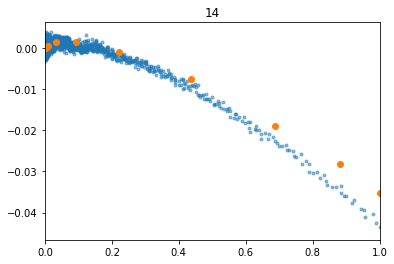

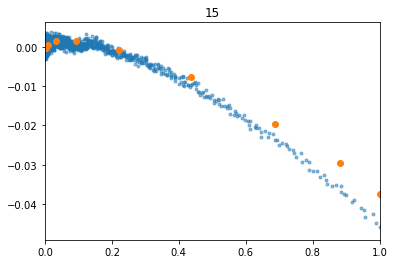

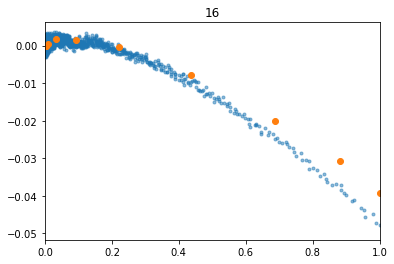

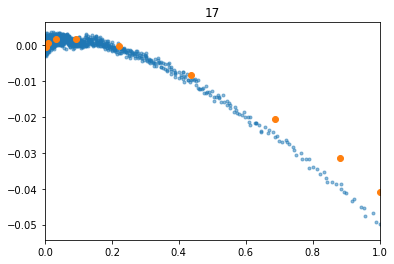

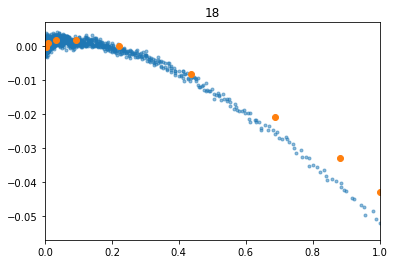

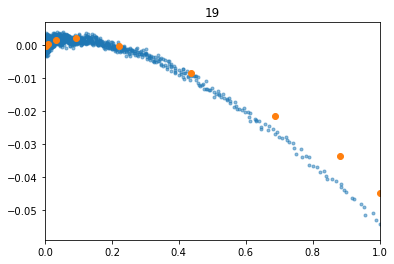

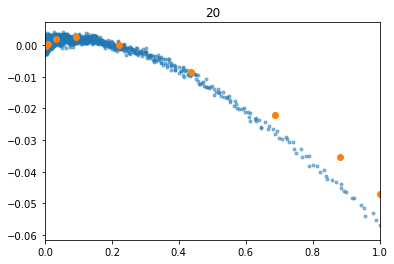

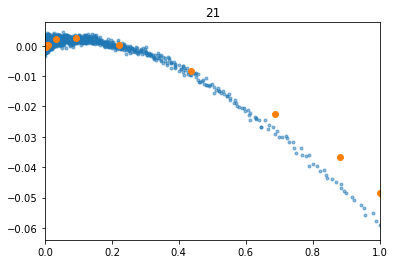

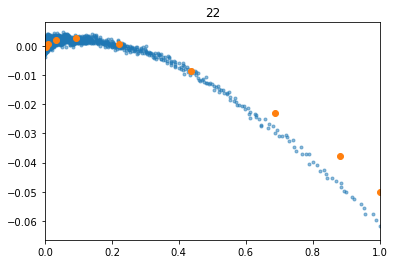

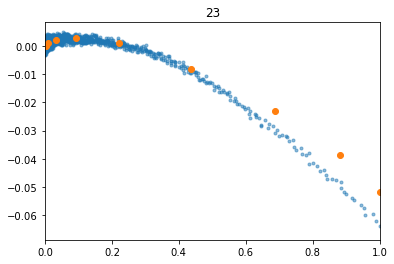

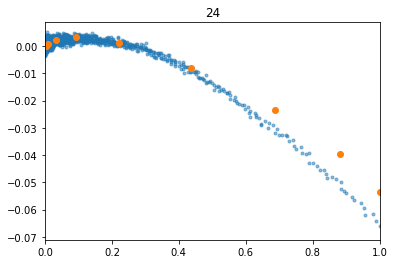

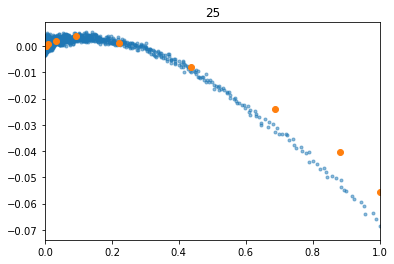

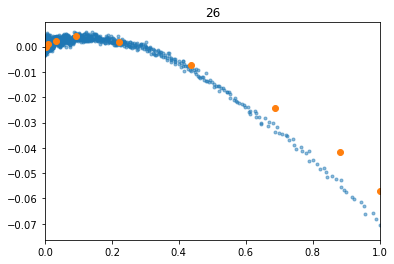

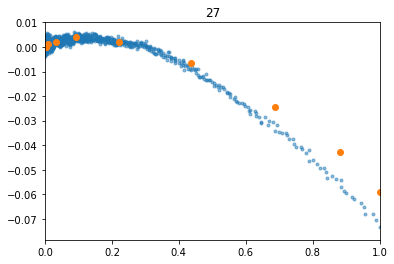

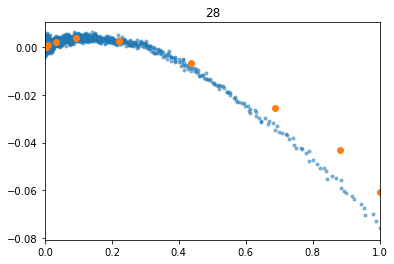

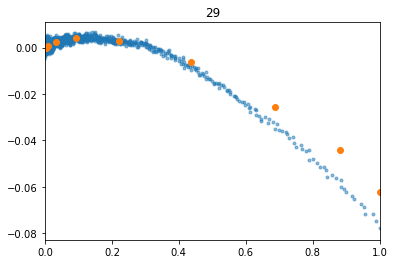

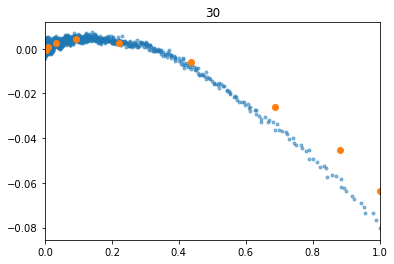

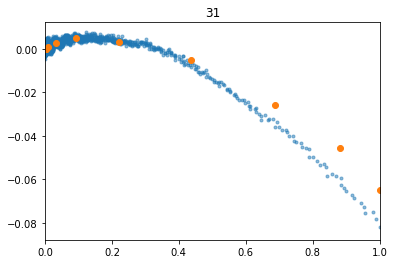

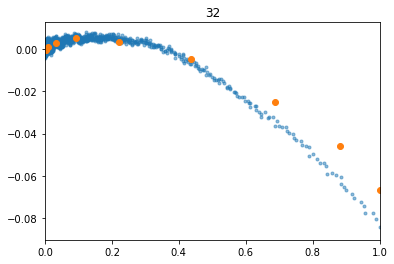

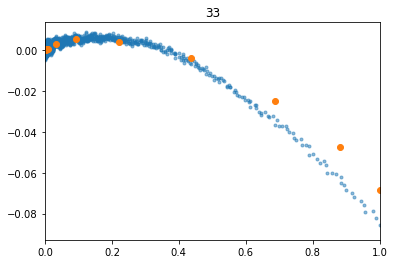

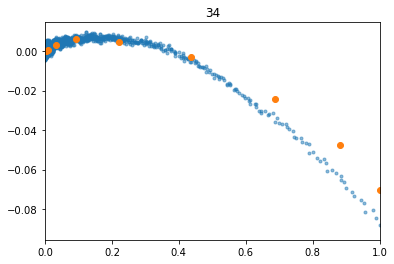

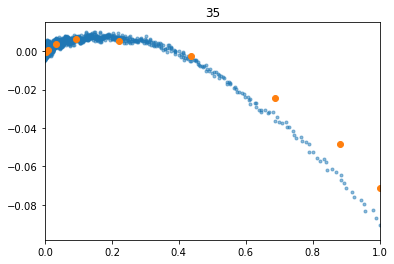

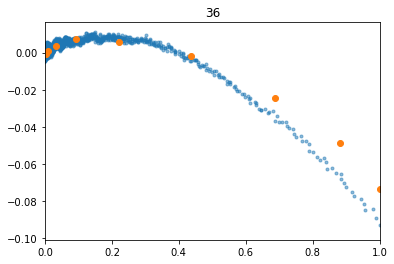

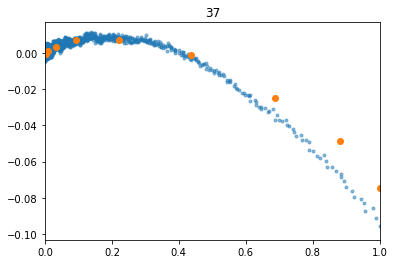

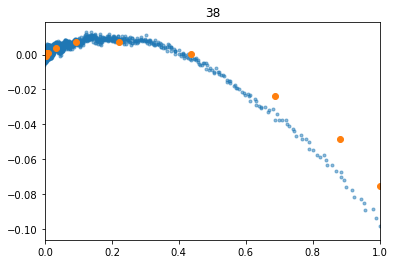

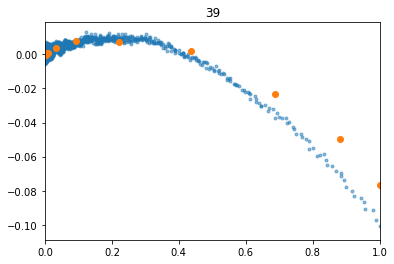

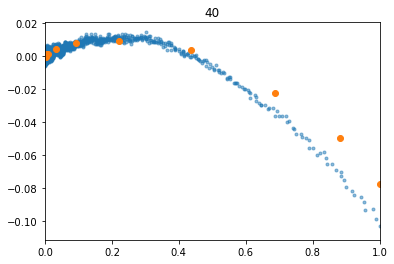

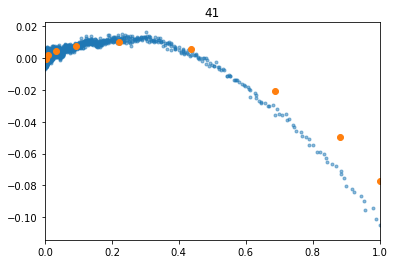

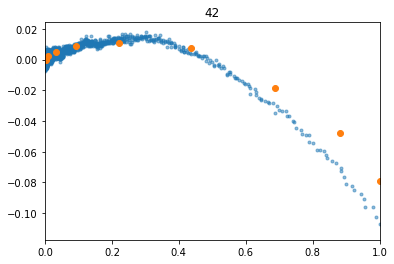

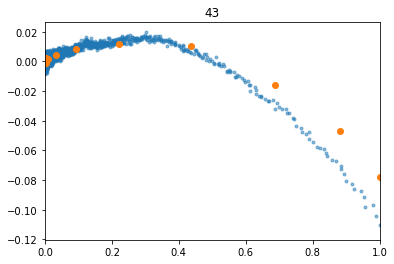

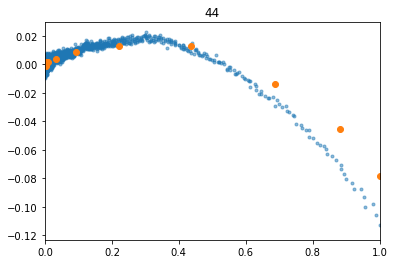

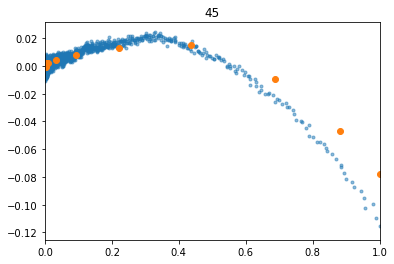

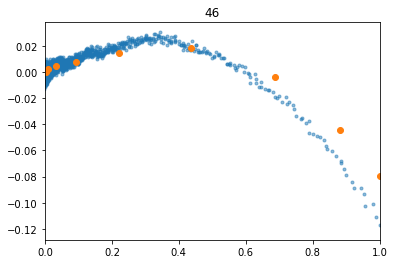

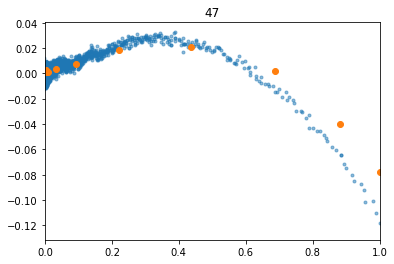

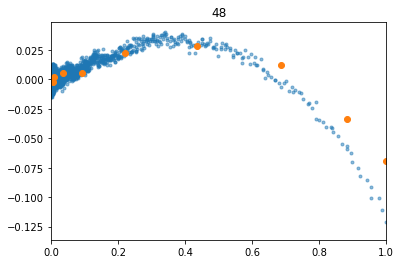

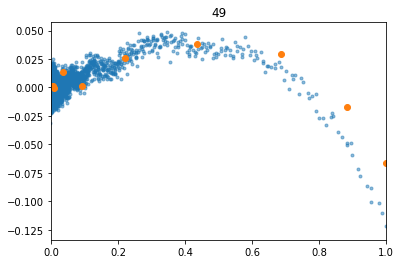

In [194]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim/pi_corr_slim[1], lohi_corr_slim[i]/(lo_slim[i]*hi_slim[i]), '.', alpha=0.5)
    plt.plot(pi_corr_mspr/pi_corr_mspr[1], lohi_corr_mspr[i], 'o')
    #plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.xlim([0,1])
    plt.show()

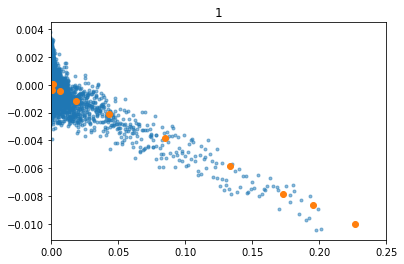

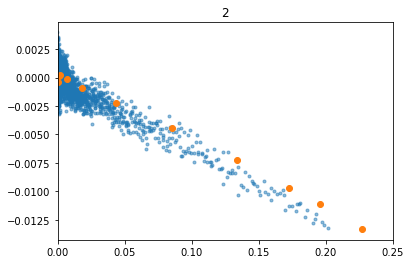

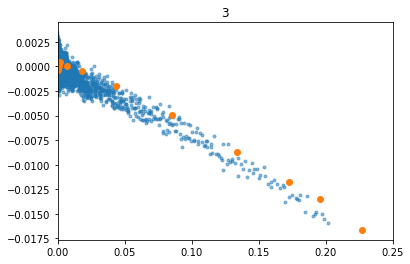

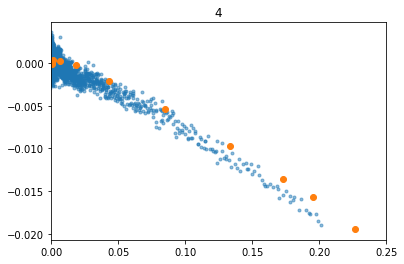

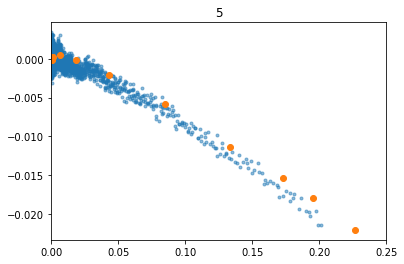

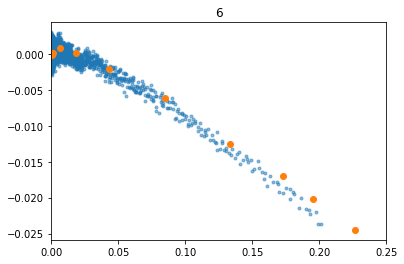

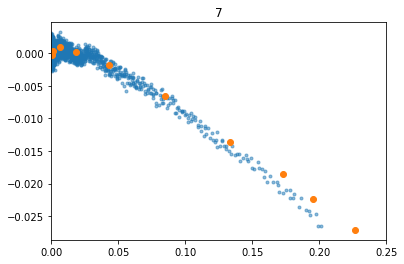

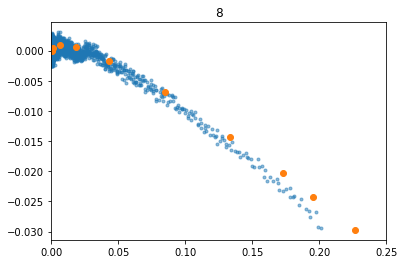

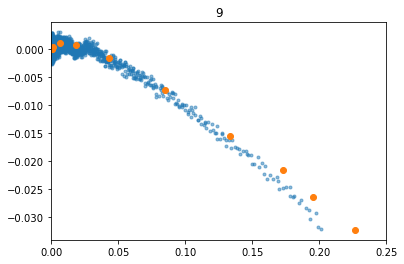

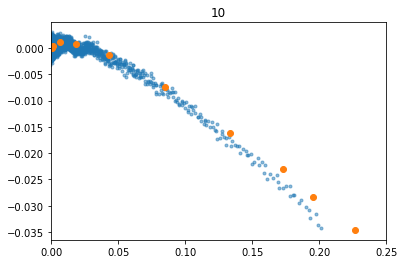

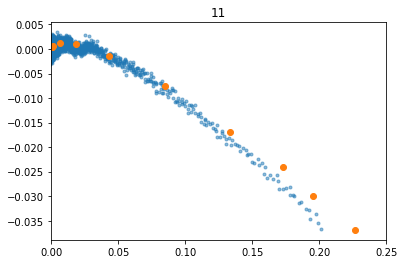

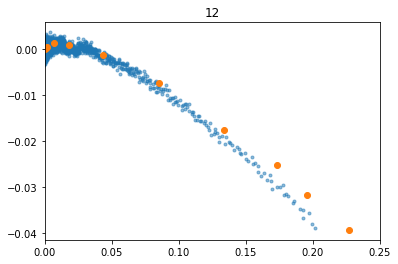

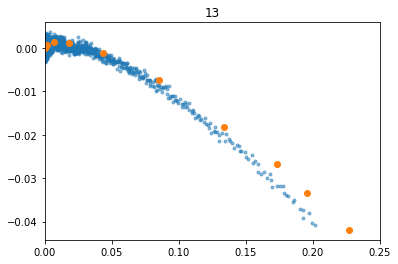

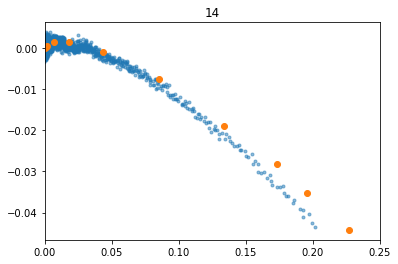

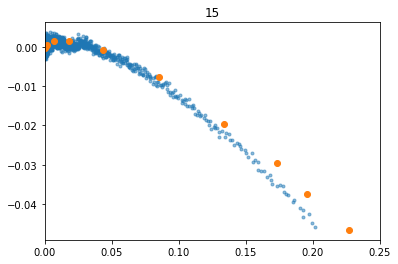

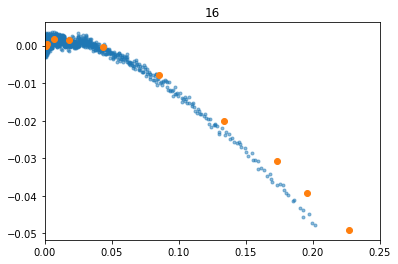

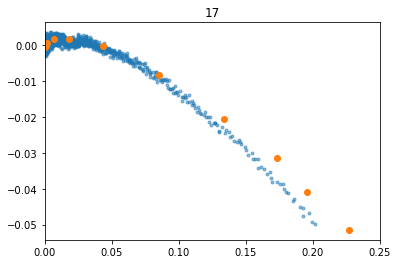

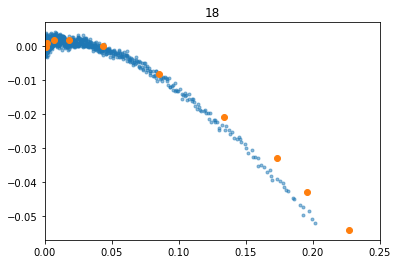

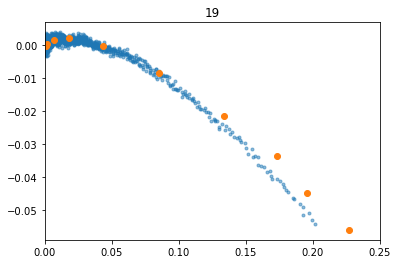

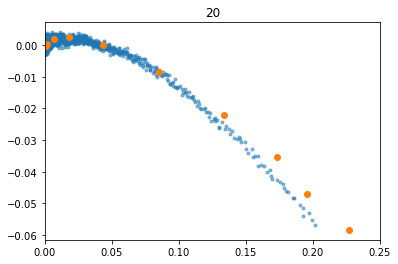

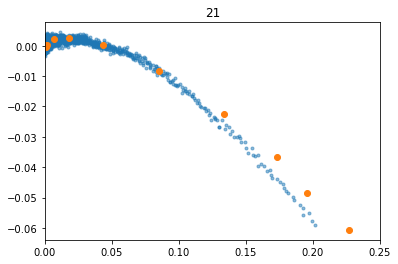

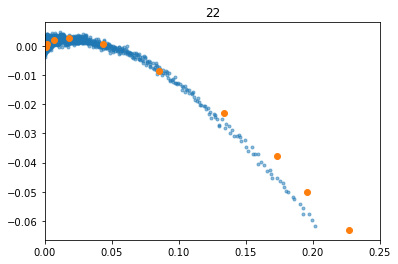

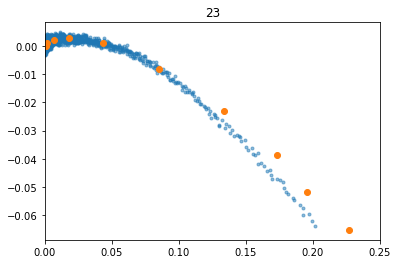

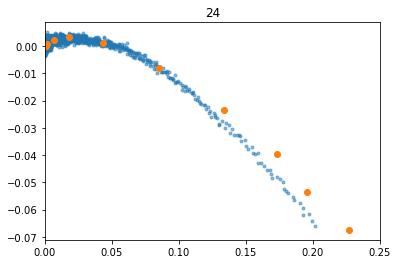

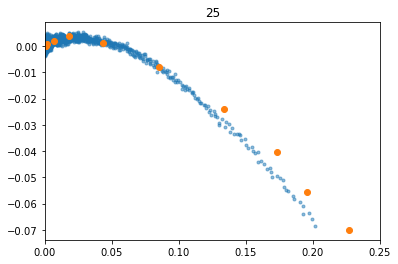

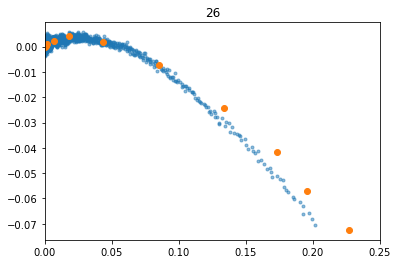

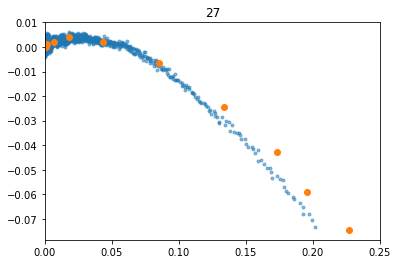

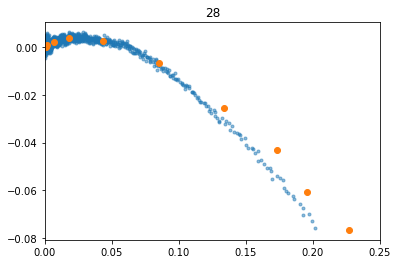

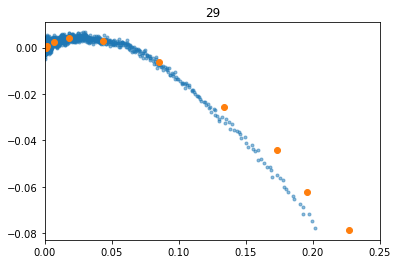

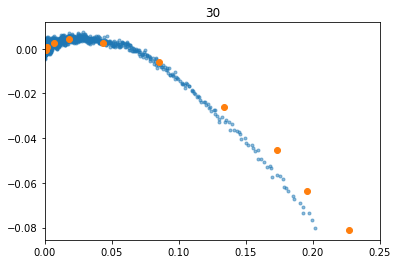

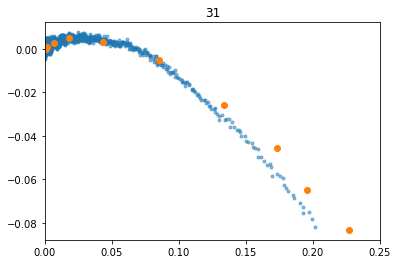

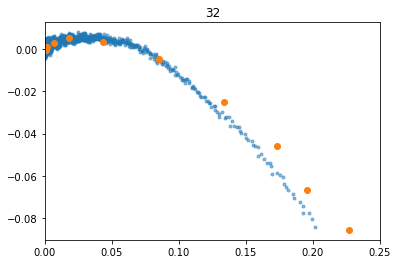

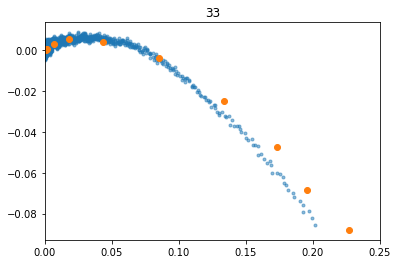

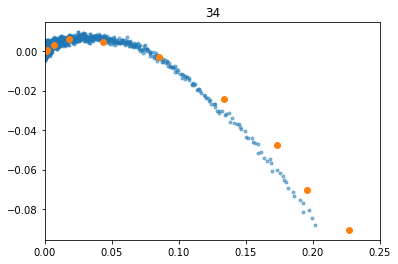

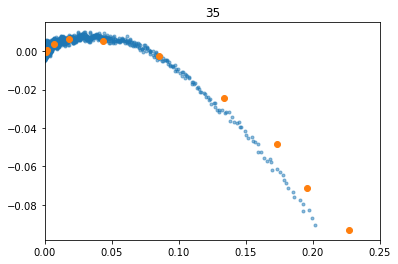

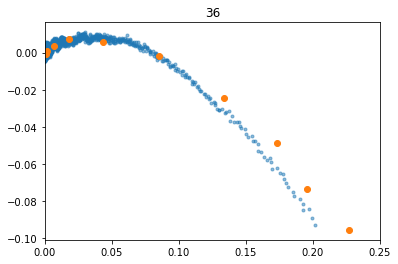

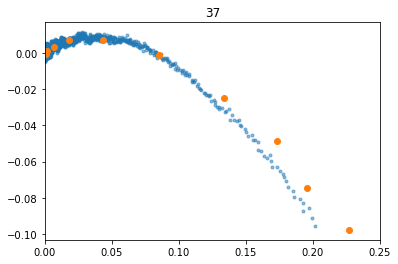

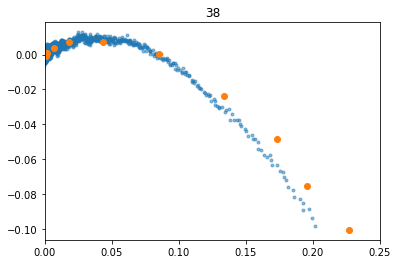

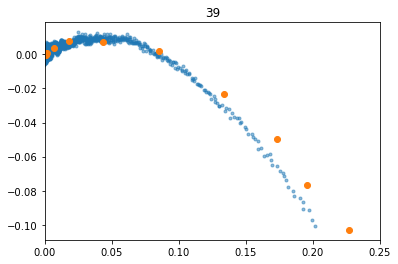

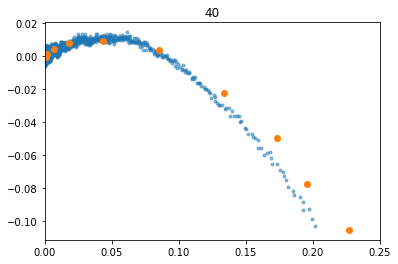

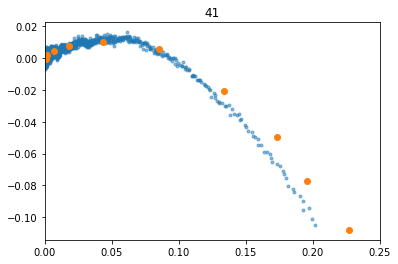

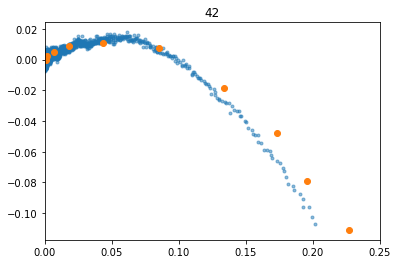

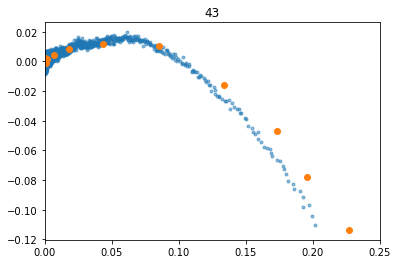

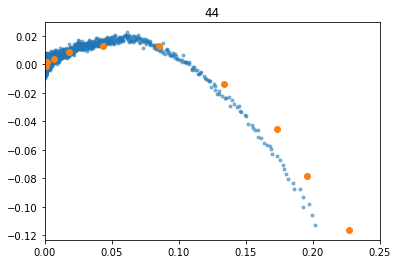

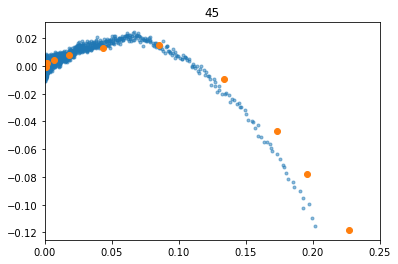

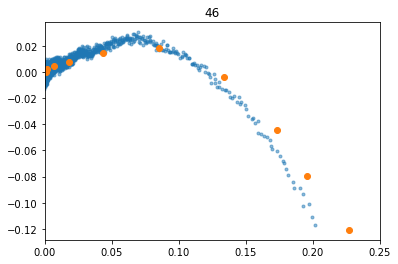

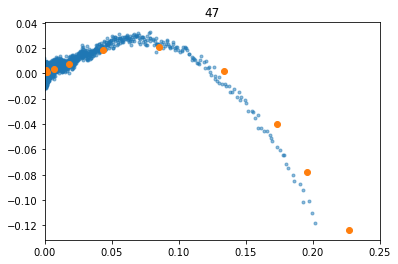

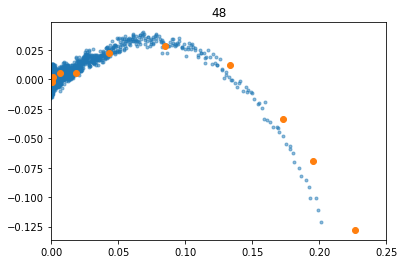

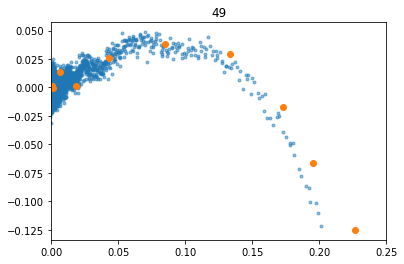

In [221]:
for cutoff in range(1,n_samples//2):
    i = cutoff - 1
    plt.plot(pi_corr_slim/pi_slim**2, lohi_corr_slim[i]/(lo_slim[i]*hi_slim[i]), '.', alpha=0.5)
    plt.plot(pi_corr_mspr/pi_mspr**2, lohi_corr_mspr[i], 'o')
    #plt.hlines(0, 1e-2, 2e2)
    plt.title(cutoff)
    plt.xlim([0,0.25])
    plt.show()

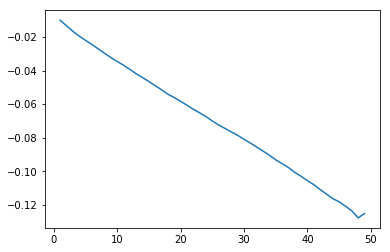

In [222]:
plt.plot(np.arange(1,n_samples//2), lohi_corr_mspr[:,0])

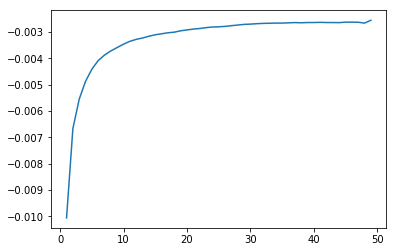

In [240]:
plt.plot(np.arange(1,n_samples//2), lohi_corr_mspr[:,0]/np.arange(1,n_samples//2))

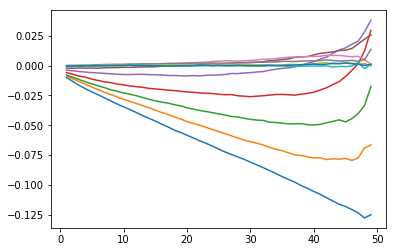

In [225]:
for i in range(len(r_list)):
    plt.plot(np.arange(1,n_samples//2), lohi_corr_mspr[:,i])

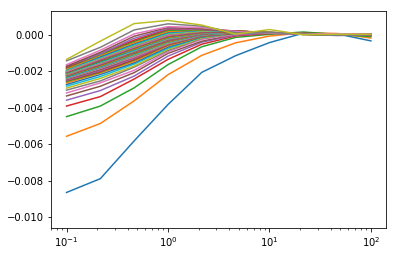

In [229]:
plt.semilogx(r_list, lohi_corr_mspr.T/np.arange(1,n_samples//2))

In [151]:
print(pi_slim)

0.000198679333495


In [157]:
print(pi_corr_mspr)
print(pi_mspr)

[ 384.59058215  379.99169041  376.23631346  371.56951315  364.21899369
  357.88052287  353.43791556  351.61113044  349.99659422  350.68459315
  350.55495094]
[ 1.99984105  1.99976596  1.9975245   2.00275723  2.00212653  2.0016864
  2.00095063  2.00158607  1.99895572  2.00272737  2.00252323]


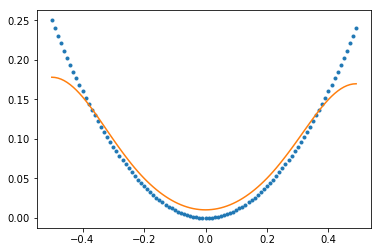

In [190]:
x = np.arange(0,1,0.01) - 0.5
y = x**2
z = h.smooth(y,51,'hamming')
plt.plot(x,y,'.')
plt.plot(x,z,'-')